In [1]:
using DelimitedFiles
using Plots; pyplot();
using UncertainData

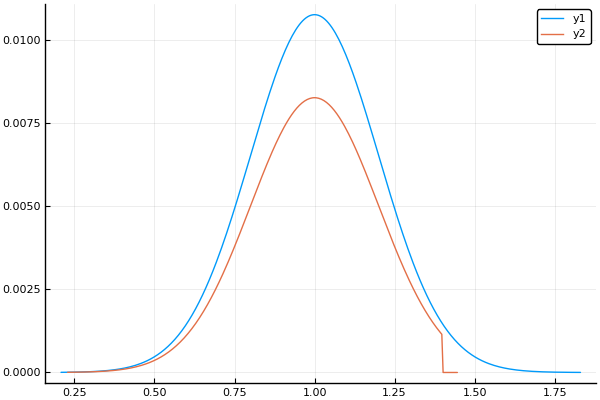

In [2]:
v = UncertainValue(Normal, 1, 0.2)
plot(v)
plot!(constrain(v, TruncateMaximum(1.4)))

# Load the age distributions

## Sea level (altitudes)
We've got 16 uncertain points indicating sea level (altitude), stored in the `SLIP_altidudes.txt` file. This file contains two columns: the first is the altitude, and the second is the `2σ` uncertainty for the altitudes, which are assumed to be normally distributed. The points are numbered consecutively from the top of the file. 


In [3]:
sealevel = readdlm("Karmøy_SLIPs/SLIP_altitudes_noheader.txt")

16×2 Array{Float64,2}:
 15.228  0.244
 11.569  0.243
  0.27   1.39 
 -3.87   2.16 
  0.27   1.39 
  6.47   0.69 
  6.47   0.69 
  3.94   1.73 
 -1.26   1.95 
 -3.95   1.65 
 -1.29   1.27 
  5.21   0.8  
  6.72   0.63 
  5.3    0.53 
  2.19   0.51 
  0.0    0.1  


## Age distributions
Each point has a unique age distribution. These are stored in text files named `SLIPXX_age.txt`,
where `XX` is a two-digit number referring to the point index. The text files each have two columns: the first representing the age and the second the empirical probability density function. 

We'll store each age distribution as an uncertain value using the `UncertainData` package.

In [4]:
n_pts = 16
agedists = Vector{AbstractUncertainValue}(undef, n_pts)
altitudes = Vector{AbstractUncertainValue}(undef, n_pts)

for i = 1:n_pts
    i < 10 ? N = "0$i" :  N = "$i"
    f = readdlm("Karmøy_SLIPs/SLIP" * N * "_age.txt")
    
    # Age distributions are represented by populations
    age, pdf = f[:, 1], f[:, 2]
    agedists[i] = UncertainValue(-age, pdf)
    
    # Altitude uncertainties are 2σ, so divide by 2 to be able to use default constructor
    # for normally distributed values.
    altitudes[i] = UncertainValue(Normal, sealevel[i, 1], sealevel[i, 2]/2)
end
idxs = UncertainIndexDataset(agedists)
vals = UncertainValueDataset(altitudes)
D = UncertainIndexValueDataset(idxs, vals)

UncertainIndexValueDataset with 16 uncertain values that each have uncertain indices.


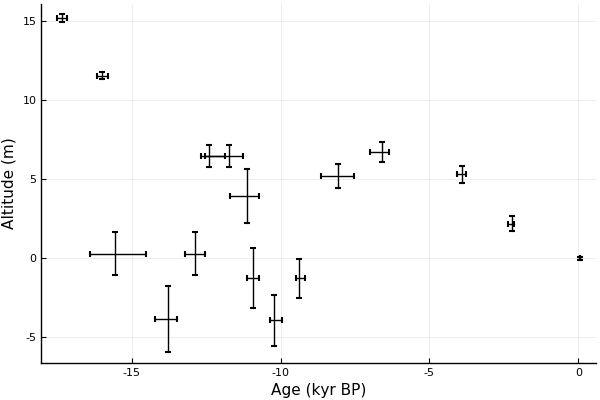

In [5]:
# Plot the distributions (95% confidence interval error bars in both directions)
p = plot(D, [0.025, 0.975], [0.025, 0.975],
    seriescolor = :black, 
    markerstrokewidth = 1,
    bar_width = 0)
xlabel!("Age (kyr BP)")
ylabel!("Altitude (m)")

We'll generate 1000 realizations of the dataset. Each realizations is drawn sequentally, imposing a strictly increasing constraint to the ages. Each realization will be interpolated linearly to a 10-year grid. 

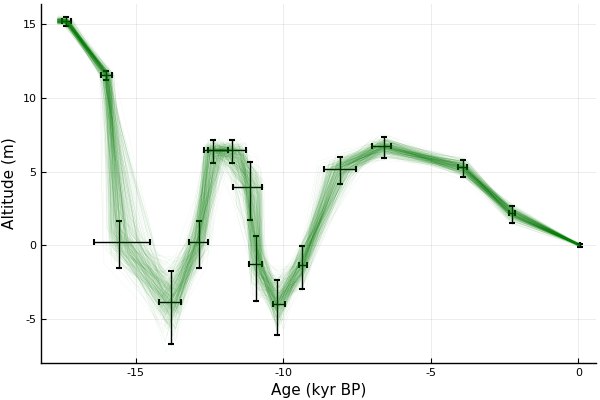

In [18]:
p2 = plot(D, [0.025, 0.975], [0.005, 0.975],
    seriescolor = :black, 
    markerstrokewidth = 1,
    bar_width = 0)
xlabel!("Age (kyr BP)")
ylabel!("Altitude (m)")

for i = 1:300
    age, rsl = resample(D, StrictlyIncreasing(), RegularGrid(D, 1/1000*10))
    plot!(age, rsl, lw = 0.2, lα = 0.1, lc = :green, label = "")
end
p2

In [19]:
savefig("resampled_300_realizations_lineplots_95percentilerange_v2_2.pdf")

Now, compute a bunch of realizations (N = 1000) and only plot the confidence intervals.

In [8]:
@time age, altitude_interpolated_realizations = resample(D, StrictlyIncreasing(), RegularGrid(D, 1/1000*50), 5000)

359.632797 seconds (11.28 M allocations: 159.837 GiB, 3.27% gc time)


(-17.658:0.05:0.042, [15.3397 15.105 … 15.2509 15.255; 15.3397 15.105 … 15.2509 15.255; … ; 0.089156 0.107742 … 0.0314516 -0.00569135; 0.0443286 0.0691048 … -0.0137753 -0.0666604])

In [9]:
n_pts = length(age)

# ~1σ
p0_16 = [quantile(altitude_interpolated_realizations[i, :], 0.16) for i = 1:n_pts]
p0_84 = [quantile(altitude_interpolated_realizations[i, :], 0.84) for i = 1:n_pts]

# ~2σ
p0_025 = [quantile(altitude_interpolated_realizations[i, :], 0.025) for i = 1:n_pts]
p0_975 = [quantile(altitude_interpolated_realizations[i, :], 0.975) for i = 1:n_pts]


m = median(altitude_interpolated_realizations, dims = 2);
m2 = mean(altitude_interpolated_realizations, dims = 2)
s = std(altitude_interpolated_realizations, dims = 2);

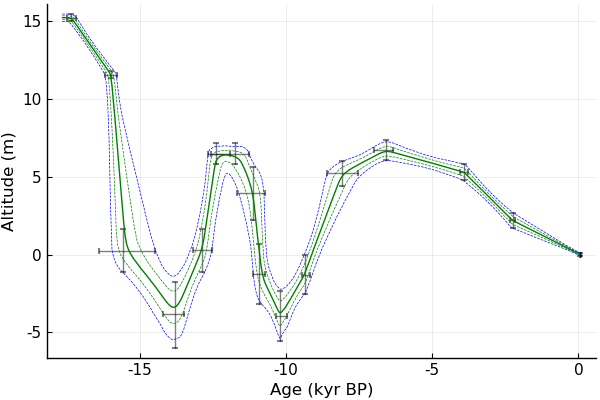

In [13]:
plot(D, [0.025, 0.975], [0.025, 0.975],
    seriescolor = :black, 
    seriesalpha = 0.5,
    markerstrokewidth = 1)
    
plot!(legend = false,
    guidefont = font(12),
    tickfont = font(11))
xlabel!("Age (kyr BP)")
ylabel!("Altitude (m)")

plot!(age, m, ls = :solid, lw = 1, lc = :green)
plot!(age, p0_16, ls = :dash, lw = 0.5, lc = :green)
plot!(age, p0_84, ls = :dash, lw = 0.5, lc = :green)

plot!(age, p0_025, ls = :dash, lw = 0.5, lc = :blue)
plot!(age, p0_975, ls = :dash, lw = 0.5, lc = :blue)

In [17]:
savefig("resampled_5000realizations_95percent_confidence_intervals_v2_2.pdf")

In [16]:
resampled = hcat(age, p0_025, p0_16, m, p0_84, p0_975, m2, s)
writedlm("resampled_5000realizations_strictlyincreasing_v2_2.txt", resampled)